## Proyecto 4: Sistema de Recomendación

In [1]:
# Importar librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import seaborn as sns
from math import sqrt
import geopandas as gpd
from dateutil.parser import parse 
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Cargar dataset
data = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
data. head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Elimino filas sin países
data = data.loc[(data['Country'] != "Unspecified")] 
# Calculo las ventas totatles
data['venta_total'] = data.Quantity * data.UnitPrice

In [ ]:
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha y los minutos/segundos en columnas separadas
data['Date'] = data['InvoiceDate'].dt.date
data['minutos_segundos'] = data['InvoiceDate'].dt.time
# Elimino la columna (que no usaré) InvoiceDate:
data = data.drop(['InvoiceDate'], axis=1)

In [26]:
data_2 = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
data_2 = data_2.sort_values('venta_total',ascending=False)
data_2 = data_2[:21]
data_2.head()

In [33]:
data_2 = data_2.sort_values('venta_total',ascending=False)
data_2 = data_2[:21]
data_2.head()

,Country,Quantity,UnitPrice,CustomerID,venta_total
36,United Kingdom,4263829,2245715.474,5.626433e+09,8187806.364
24,Netherlands,200128,6492.550,3.419054e+07,284661.540
33,Switzerland,30325,6813.690,2.377592e+07,56385.350
31,Spain,26824,12633.450,3.268929e+07,54774.580
32,Sweden,35637,1806.830,6.790083e+06,36595.910


## Gráficos

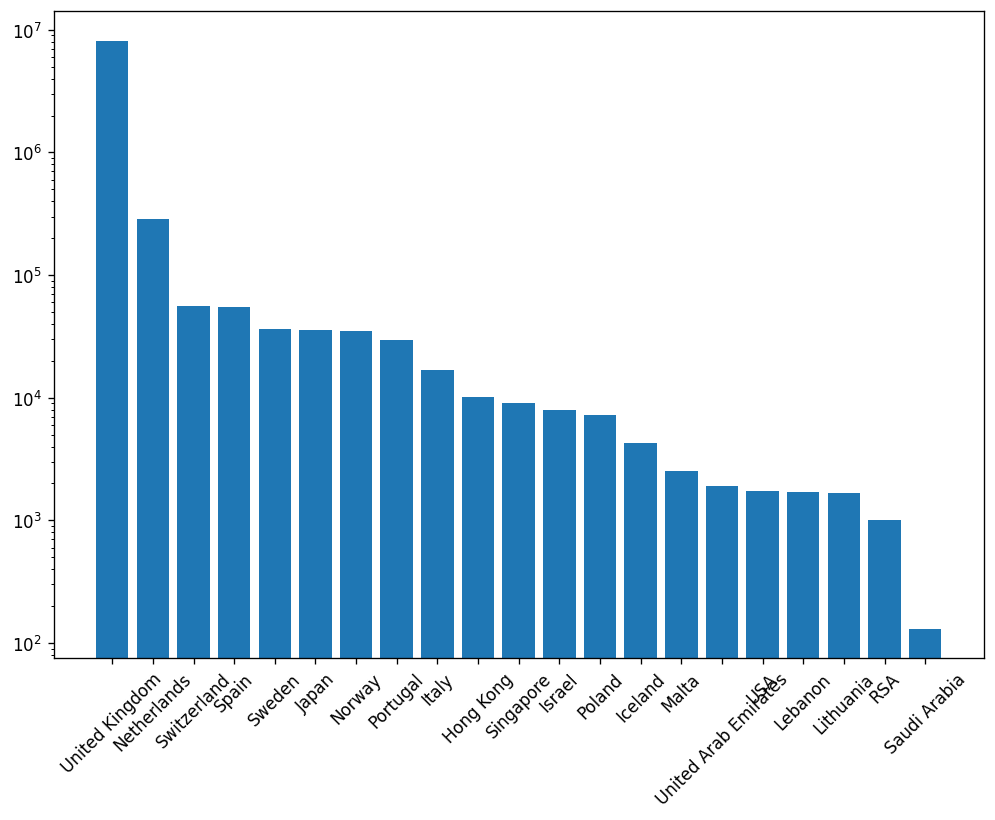

In [34]:
# Crear la gráfica de barras
plt.bar(data_2.Country, data_2['venta_total'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

C:\Users\n_sar\AppData\Local\Temp\ipykernel_19480\2280756293.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot: >

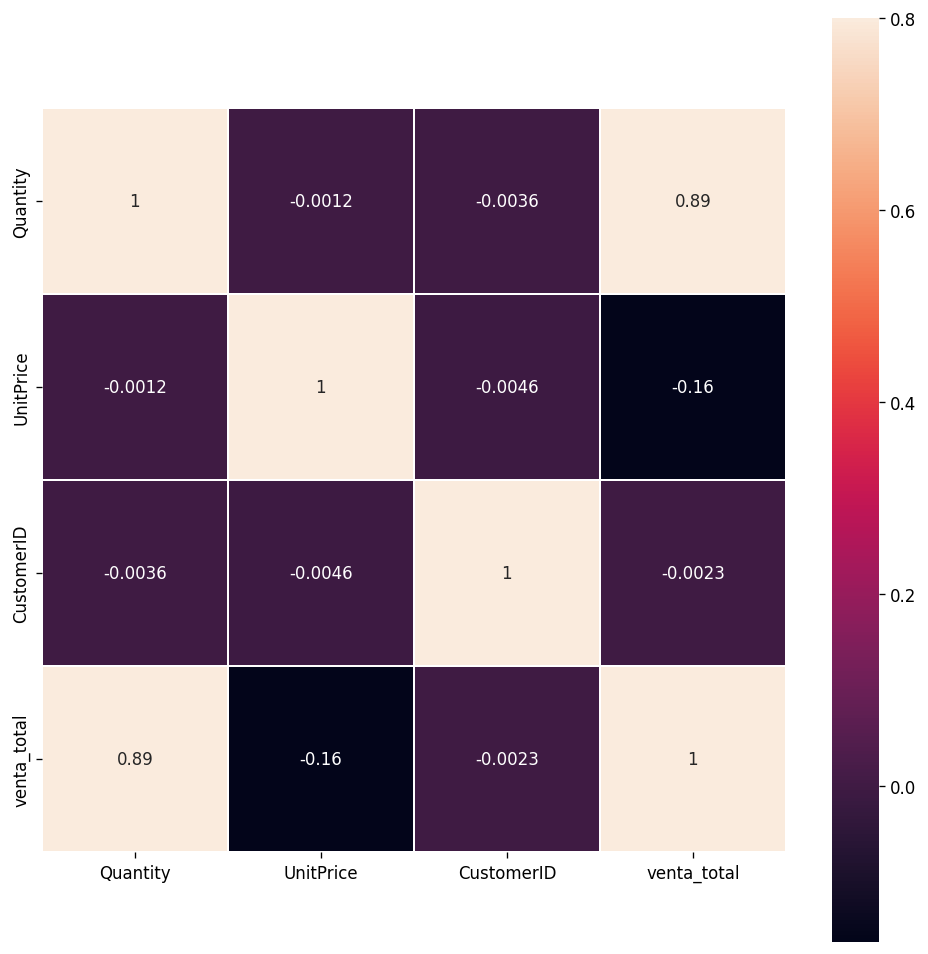

In [28]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)

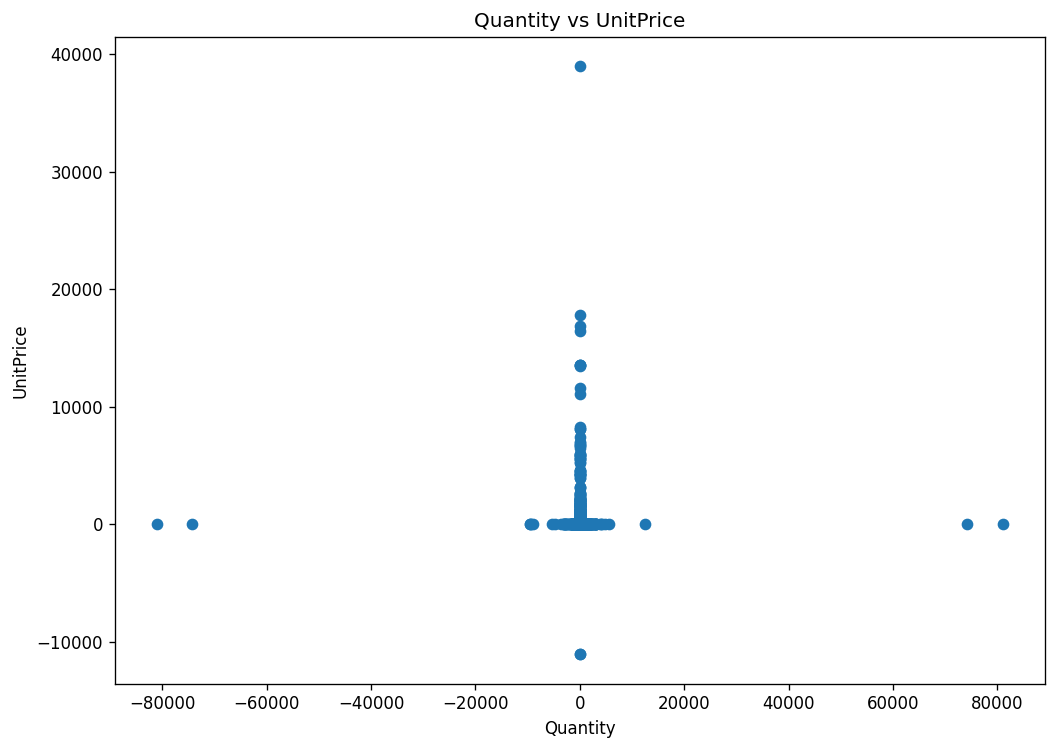

In [48]:
# Gráfica de dispersión (scatter) de Quantity vs UnitPrice 
plt.scatter(data['Quantity'], data['UnitPrice'])
plt.title("Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.show()

In [ ]:
# Seaborn o PairGrid:
sns.pairplot(data, x_vars=['Country','Quantity', 'UnitPrice'], y_vars=['venta_total'], kind="reg")
#sns.pairplot(data, x_vars=['Country','UnitPrice', 'StockCode', 'Date'], y_vars=['Quantity'], kind="reg")

In [ ]:
titles=' '.join(data.Description).lower()
plt.figure(figsize=(15,10))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [35]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Ver el listado completo
pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
5                    Kazakhstan
6                    Uzbekistan
7              Papua New Guinea
8                     Indonesia
9                     Argentina
10                        Chile
11              Dem. Rep. Congo
12                      Somalia
13                        Kenya
14                        Sudan
15                         Chad
16                        Haiti
17               Dominican Rep.
18                       Russia
19                      Bahamas
20                 Falkland Is.
21                       Norway
22                    Greenland
23       Fr. S. Antarctic Lands
24                  Timor-Leste
25                 South Africa
26                      Lesotho
27                       Mexico
28                      Uruguay
29                       Brazil
30  

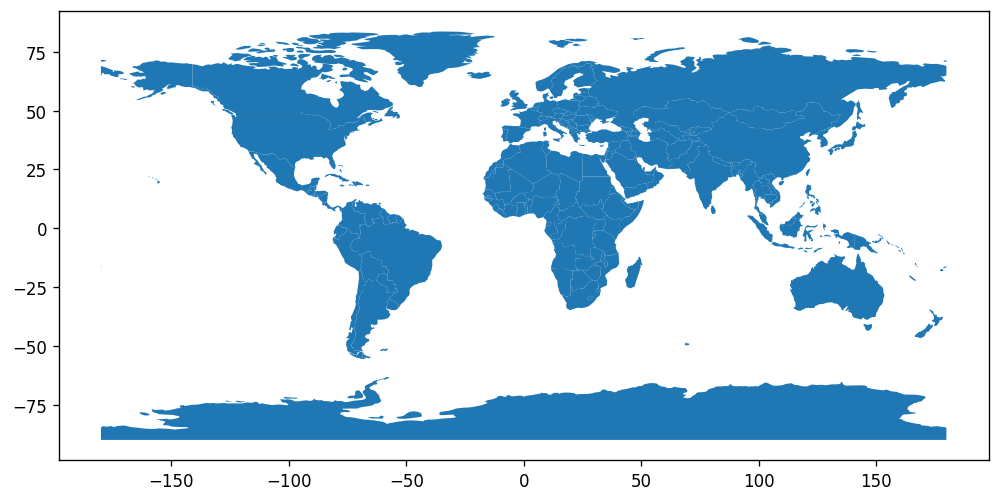

In [36]:
# Verificar si coincide losnombre d elos países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
plt.show()   

In [ ]:
# Unir los datos de los países con los datos de ventas por país
df = paises_geo_pandas.merge(data, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))
# Dibujar los países en el mapa y colorearlos según las ventas
df.plot(ax=ax, column='Quantity', cmap='Blues', linewidth=0.8, edgecolor='black', legend=True)
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

In [ ]:
# Dibujar los países en el mapa y colorearlos según las ventas
data.plot(ax=ax, column='Ventas', cmap='cividis_r', linewidth=0.8, edgecolor='black', legend=True, legend_kwds={'orientation': "horizontal"})

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [47]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,venta_total,Date
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,16446.0,United Kingdom,168469.60,2011-12-09
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,77183.60,2011-01-18
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,649.50,15098.0,United Kingdom,38970.00,2011-06-10
15017,537632,AMAZONFEE,AMAZON FEE,1,13541.33,NaN,United Kingdom,13541.33,2010-12-07
299982,A563185,B,Adjust bad debt,1,11062.06,NaN,United Kingdom,11062.06,2011-08-12


In [ ]:
horarios_cant_vta = data.groupby(['minutos_segundos'], group_keys=False, as_index=False).sum('Quantity')
horarios_cant_vta = horarios_cant_vta[::50]
horarios_cant_vta.head()

In [ ]:
# Crear la gráfica de barras
plt.bar(horarios_cant_vtas.minutos_segundos, horarios_cant_vtas['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

In [45]:
calendario_cant_vta = data.groupby(['Date'], group_keys=False, as_index=False).sum('Quantity')
#calendario_cant_vta = calendario_cant_vta.sort_values('Date',ascending=False)
calendario_cant_vta = calendario_cant_vta[::100]
calendario_cant_vta.head()

,Date,Quantity,UnitPrice,CustomerID,venta_total
0,2010-12-01,26814,12904.25,30821613.0,58635.56
100,2011-04-07,10356,4707.59,19849351.0,18229.00
200,2011-08-09,15605,4280.67,14128856.0,26623.20
300,2011-12-05,44119,57195.74,51763938.0,57751.32


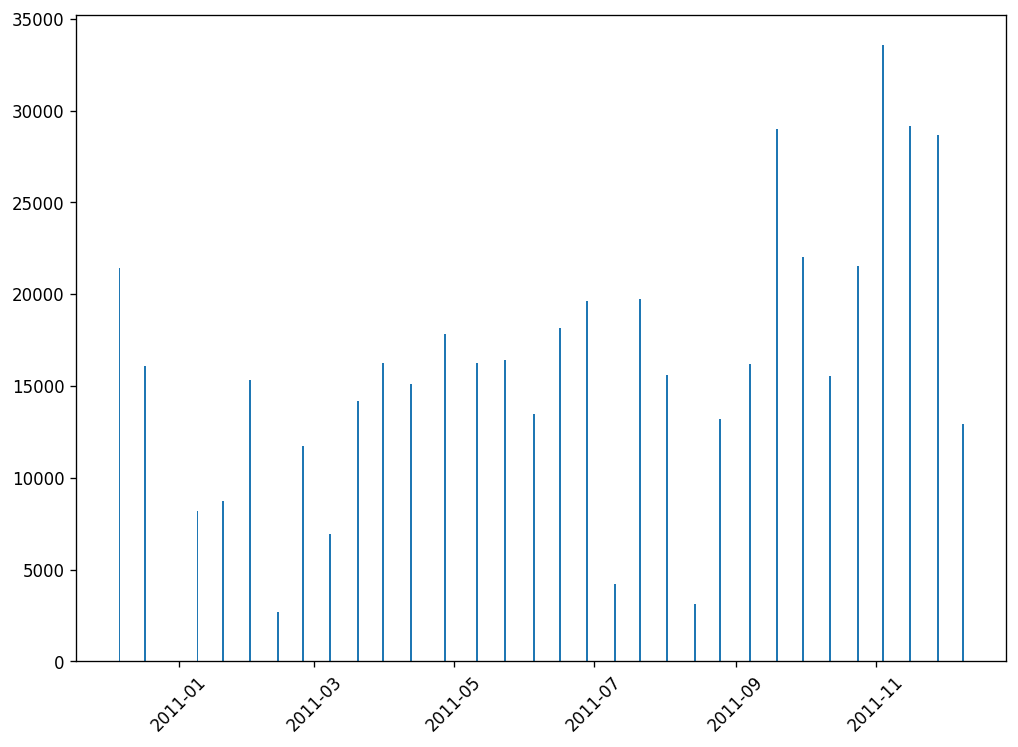

In [46]:
# Crear la gráfica de barras
plt.bar(calendario_cant_vtas.Date, calendario_cant_vtas['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot: >

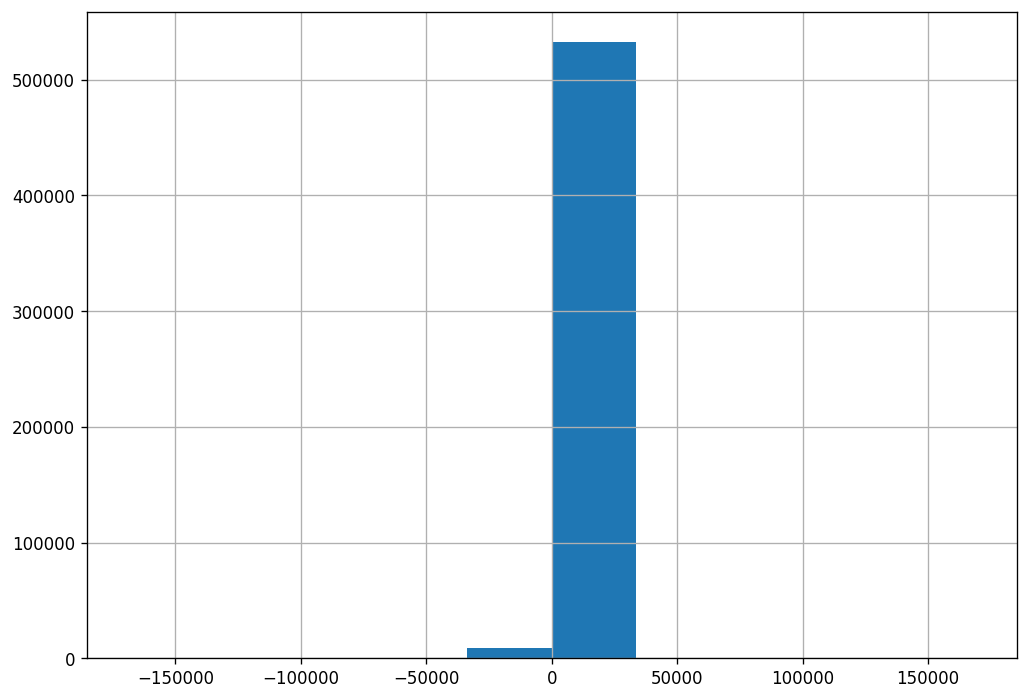

In [55]:
# Historama: Buscando bins más significativos (30 días = 1 mes)
data.venta_total.hist(bins=30)

<AxesSubplot: >

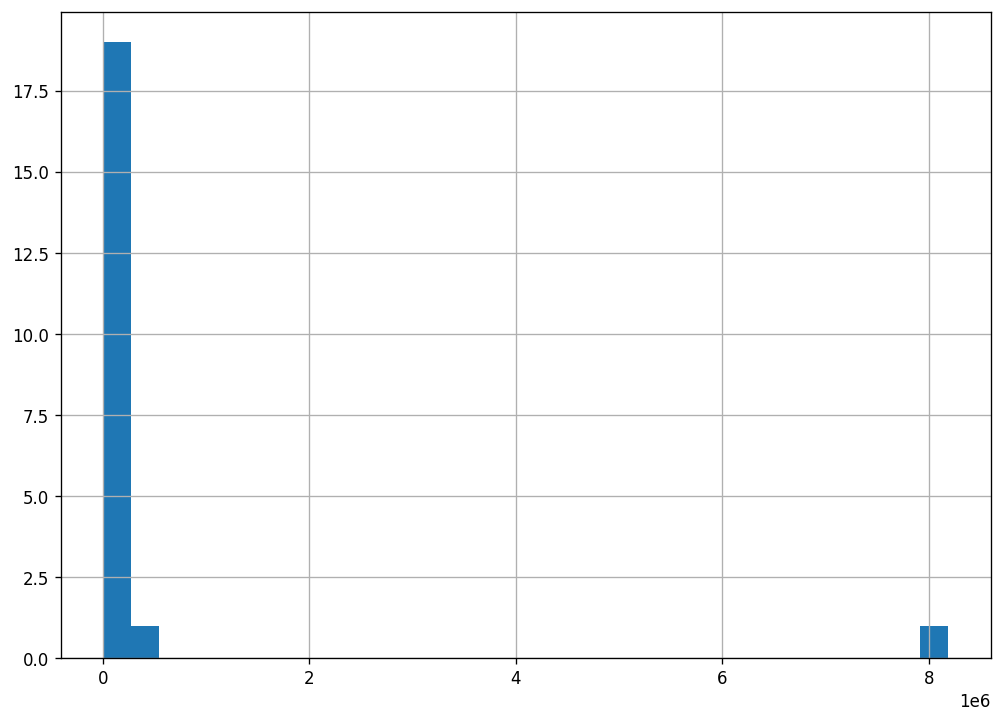

In [59]:
data_2.venta_total.hist(bins=30)

}4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [35]:
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID', 'Description'], columns=['Date'], aggfunc=np.sum)
#Customer_Item = pd.pivot_table(data, values='Quantity', index=['Country'], aggfunc=np.sum)
Customer_Item

Date                                            2010-12-01  2010-12-02  \
CustomerID Description                                                   
12346.0    MEDIUM CERAMIC TOP STORAGE JAR              NaN         NaN   
12347.0    3D DOG PICTURE PLAYING CARDS                NaN         NaN   
           3D SHEET OF CAT STICKERS                    NaN         NaN   
           3D SHEET OF DOG STICKERS                    NaN         NaN   
           60 TEATIME FAIRY CAKE CASES                 NaN         NaN   
...                                                    ...         ...   
18287.0    PACK OF 12 VINTAGE CHRISTMAS TISSUE         NaN         NaN   
           PAINTED METAL HEART WITH HOLLY BELL         NaN         NaN   
           S/4 IVORY MINI ROSE CANDLE IN BOWL          NaN         NaN   
           BLUE CIRCLES DESIGN MONKEY DOLL             NaN         NaN   
           FOLK ART METAL STAR T-LIGHT HOLDER          NaN         NaN   

Date                                            2010-12-03  2010-12-05  \
CustomerID Description                                                   
12346.0    MEDIUM CERAMIC TOP STORAGE JAR              NaN         NaN   
12347.0    3D DOG PICTURE PLAYING CARDS                NaN         NaN   
           3D SHEET OF CAT STICKERS                    NaN         NaN   
           3D SHEET OF DOG STICKERS                    NaN         NaN   
           60 TEATIME FAIRY CAKE CASES                 NaN         NaN   
...                                                    ...         ...   
18287.0    PACK OF 12 VINTAGE CHRISTMAS TISSUE         NaN         NaN   
           PAINTED METAL HEART WITH HOLLY BELL         NaN         NaN   
           S/4 IVORY MINI ROSE CANDLE IN BOWL          NaN         NaN   
           BLUE CIRCLES DESIGN MONKEY DOLL             NaN         NaN   
           FOLK ART METAL STAR T-LIGHT HOLDER          NaN         NaN   

Date                                            2010-12-06  2010-12-07  \
CustomerID Description                                                   
12346.0    MEDIUM CERAMIC TOP STORAGE JAR              NaN         NaN   
12347.0    3D DOG PICTURE PLAYING CARDS                NaN        24.0   
           3D SHEET OF CAT STICKERS                    NaN         NaN   
           3D SHEET OF DOG STICKERS                    NaN         NaN   
           60 TEATIME FAIRY CAKE CASES                 NaN         NaN   
...                                                    ...         ...   
18287.0    PACK OF 12 VINTAGE CHRISTMAS TISSUE         NaN         NaN   
           PAINTED METAL HEART WITH HOLLY BELL         NaN         NaN   
           S/4 IVORY MINI ROSE CANDLE IN BOWL          NaN         NaN   
           BLUE CIRCLES DESIGN MONKEY DOLL             NaN         NaN   
           FOLK ART METAL STAR T-LIGHT HOLDER          NaN         NaN   

Date                                            2010-12-08  2010-12-09  \
CustomerID Description                                                   
12346.0    MEDIUM CERAMIC TOP STORAGE JAR              NaN         NaN   
12347.0    3D DOG PICTURE PLAYING CARDS                NaN         NaN   
           3D SHEET OF CAT STICKERS                    NaN         NaN   
           3D SHEET OF DOG STICKERS                    NaN         NaN   
           60 TEATIME FAIRY CAKE CASES                 NaN         NaN   
...                                                    ...         ...   
18287.0    PACK OF 12 VINTAGE CHRISTMAS TISSUE         NaN         NaN   
           PAINTED METAL HEART WITH HOLLY BELL         NaN         NaN   
           S/4 IVORY MINI ROSE CANDLE IN BOWL          NaN         NaN   
           BLUE CIRCLES DESIGN MONKEY DOLL             NaN         NaN   
           FOLK ART METAL STAR T-LIGHT HOLDER          NaN         NaN   

Date                                            2010-12-10  2010-12-12  ...  \
CustomerID Description                                               

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [46]:
# Convertir CustomerID (float) en un array.
CustomerID = pd.DataFrame(data=np.random.randint(0, 10000, (1000,8)),columns=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Date'])
nmp=CustomerID.to_numpy()
print(nmp) 
print(type(nmp))

[[7379 7097 4686 ... 6048 3916 7304]
 [3063 7716 8973 ... 9597 5611 4669]
 [6980 1911 4531 ... 3613 6229 8713]
 ...
 [6363 4142 9638 ... 3443 5021 1037]
 [1372 1785 7111 ... 1023 6589 7963]
 [1056 3935 1642 ... 8831 1519 1921]]
<class 'numpy.ndarray'>


In [47]:
from scipy.spatial.distance import squareform

In [48]:
distances = pdist(CustomerID, metric="cosine")
cosineDistance = squareform(distances)
cosineDistance

array([[0.        , 0.18216654, 0.0926139 , ..., 0.21072984, 0.29428903,
        0.24458868],
       [0.18216654, 0.        , 0.34181479, ..., 0.13751078, 0.18647437,
        0.14843473],
       [0.0926139 , 0.34181479, 0.        , ..., 0.2739678 , 0.23797846,
        0.43140672],
       ...,
       [0.21072984, 0.13751078, 0.2739678 , ..., 0.        , 0.21586165,
        0.34135688],
       [0.29428903, 0.18647437, 0.23797846, ..., 0.21586165, 0.        ,
        0.47568752],
       [0.24458868, 0.14843473, 0.43140672, ..., 0.34135688, 0.47568752,
        0.        ]])

In [49]:
cosineSimilarity = 1 - cosineDistance
cosineSimilarity

array([[1.        , 0.81783346, 0.9073861 , ..., 0.78927016, 0.70571097,
        0.75541132],
       [0.81783346, 1.        , 0.65818521, ..., 0.86248922, 0.81352563,
        0.85156527],
       [0.9073861 , 0.65818521, 1.        , ..., 0.7260322 , 0.76202154,
        0.56859328],
       ...,
       [0.78927016, 0.86248922, 0.7260322 , ..., 1.        , 0.78413835,
        0.65864312],
       [0.70571097, 0.81352563, 0.76202154, ..., 0.78413835, 1.        ,
        0.52431248],
       [0.75541132, 0.85156527, 0.56859328, ..., 0.65864312, 0.52431248,
        1.        ]])

In [59]:
cosine_sim = cosine_similarity(CustomerID) 
#cosine_sim = cosine_similarity(StockCode)
cosine_sim

array([[1.        , 0.81783346, 0.9073861 , ..., 0.78927016, 0.70571097,
        0.75541132],
       [0.81783346, 1.        , 0.65818521, ..., 0.86248922, 0.81352563,
        0.85156527],
       [0.9073861 , 0.65818521, 1.        , ..., 0.7260322 , 0.76202154,
        0.56859328],
       ...,
       [0.78927016, 0.86248922, 0.7260322 , ..., 1.        , 0.78413835,
        0.65864312],
       [0.70571097, 0.81352563, 0.76202154, ..., 0.78413835, 1.        ,
        0.52431248],
       [0.75541132, 0.85156527, 0.56859328, ..., 0.65864312, 0.52431248,
        1.        ]])

In [51]:
cosine_sim.shape

(1000, 1000)

In [54]:
# Convertir matriz dispersa a una matriz densa
dense_matrix = cosine_sim.todense()
print(dense_matrix)

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

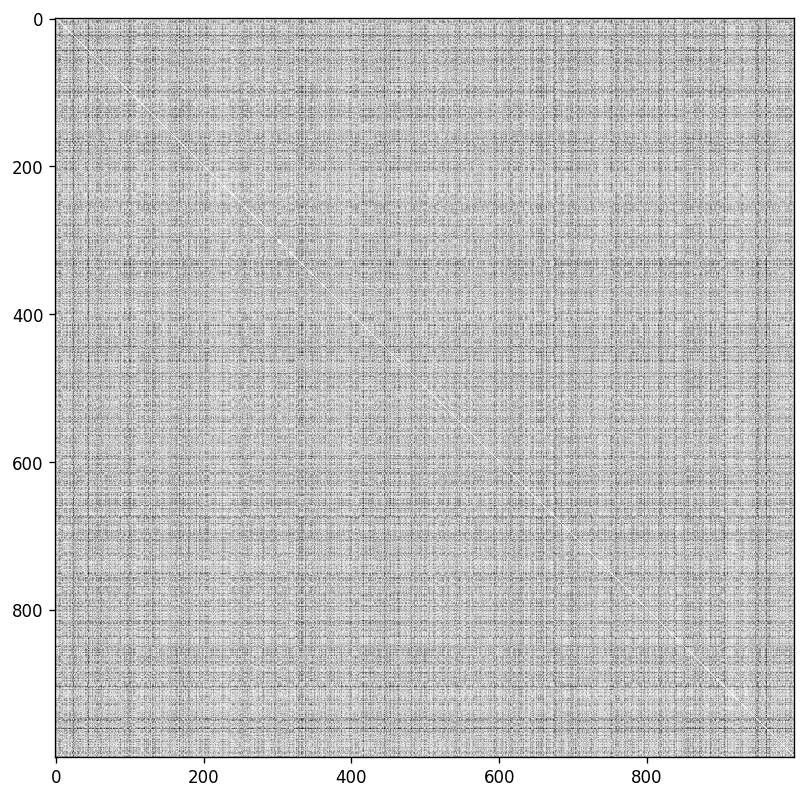

In [57]:
# Graficar matriz densa
plt.imshow(cosine_sim, cmap='gray', interpolation='nearest')
plt.show()

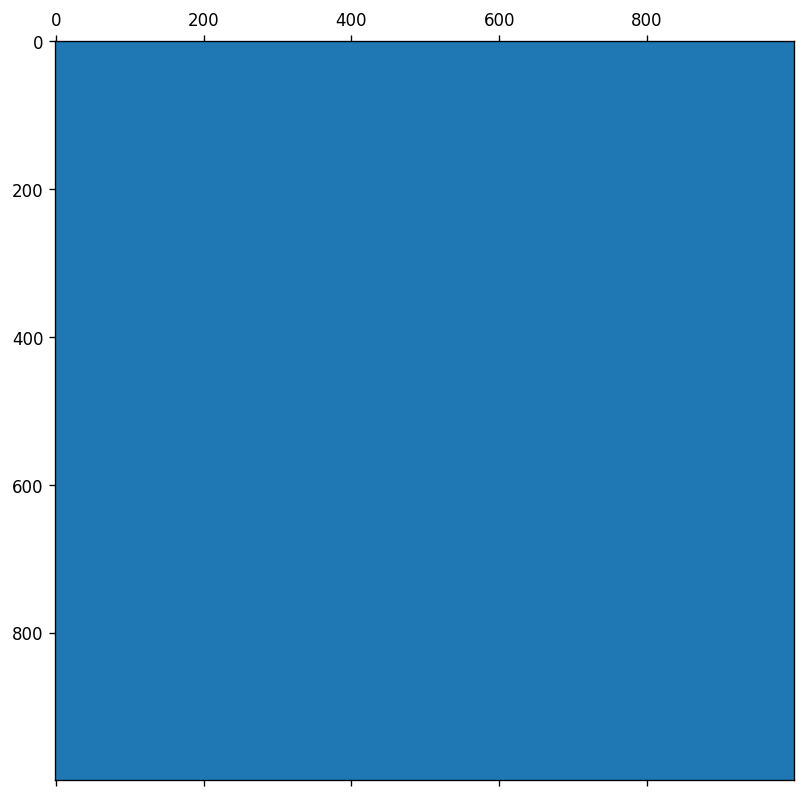

In [56]:
# Graficar matriz dispersa
plt.spy(cosine_sim, markersize=5)
plt.show()

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

In [55]:
# pip3 install apyori
from apyori import apriori

In [56]:
# Crear un conjunto de datos de ejemplo de transacciones de compra
productos = [['Leche', 'Pan', 'Queso'],
         ['Leche', 'Pan'],
         ['Leche', 'Queso'],
         ['Leche', 'Pan', 'Queso'],
         ['Leche', 'Pan', 'Queso', 'Huevos'],
         ['Leche', 'Pan', 'Huevos']]

# Utilizar el algoritmo Apriori para generar conjuntos de elementos frecuentes y reglas de asociación
conjuntos_frecuentes = list(apriori(productos, min_support=0.2, min_confidence=0.7, min_lift=1.2))

In [57]:
# Imprimir los conjuntos de elementos frecuentes y las reglas de asociación resultantes
print("Conjuntos Frecuentes:")
for conjunto in conjuntos_frecuentes:
    print(conjunto.items)
print("\nReglas de Asociación:")
for conjunto in conjuntos_frecuentes:
    for regla in conjunto.ordered_statistics:
        antecedente = list(regla.items_base)
        consecuente = list(regla.items_add)
        confianza = regla.confidence
        lift = regla.lift
        print(f"{antecedente} -> {consecuente}, confianza = {confianza:.2f}, lift = {lift:.2f}")

Conjuntos Frecuentes:
frozenset({'Huevos', 'Pan'})
frozenset({'Huevos', 'Pan', 'Leche'})

Reglas de Asociación:
['Huevos'] -> ['Pan'], confianza = 1.00, lift = 1.20
['Huevos'] -> ['Pan', 'Leche'], confianza = 1.00, lift = 1.20
['Huevos', 'Leche'] -> ['Pan'], confianza = 1.00, lift = 1.20


8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

In [61]:
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Extraemos las pablabra  
contador = CountVectorizer() 
# Codificamos como un vector
vectorizador = TfidfVectorizer(max_features=10)  
# Crear una matriz dispersa
cantidades = contador.fit_transform(palabras.texto)
valores = vectorizador.fit_transform(palabras.texto)
print ("Vector de cantidades")
print (cantidades)
print ("Vector de valores")
print (valores)

# Ejemplo de documentos de prueba
# texto = ['Este es el primer documento', 'Este es el segundo documento', 'Este es el tercer documento', 'Este es el cuarto documento']

# Matriz de vectores de texto con la técnica de bolsa de palabras
vectorizer = CountVectorizer()
texto_vectores = vectorizer.fit_transform(texto)
# Calculo la similitud coseno entre el primer texto y los demás
# El primer texto uso como consulta
query_vector = texto_vectores[0] 
coseno_similares = cosine_similarity(query_vector, texto_vectores)
# Ordeno los textos por similitud coseno
most_similar_texto = coseno_similares.argsort()[0][::-1]

# Imprimo los textos más cercanos al primer documento
print('Documentos más cercanos al primer documento:')
for texto_index in most_similar_texto[1:]:
    print(texto[texto_index])

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.

In [25]:
# Librerías
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Ejemplo de KNN con datos sencillos (unidimensionales, sólo 1 columna)
train = np.array([[0.70436073, 0.91564351, 0.9931506, 2.26418779]])
train_1 = train.reshape(-1, 1) # https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
label = np.array([['1','1','1','0']])
label_1 = label.reshape(-1, 1)

print("train:", train)
print("train_1:", train_1)
print("label:", label)
print("label_1:", label_1)

# Ploteamos
plt.scatter(train[0], label[0])
plt.show()

knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(train_1, label_1)

# Agregamos un nuevo punto también alejado, con intención de que lo identifique como label = 0
test = np.array([[0.70436073, 0.91564351, 0.9931506, 2.26418779, 2.5]])
test_1 = test.reshape(-1, 1)
predLabel = knn.predict(test_1)
print(predLabel)

# Dibujamos la predicción (clasificación)
plt.scatter(test[0], predLabel)
plt.scatter(test[0][-1:], predLabel[-1:], color="red") # pintamos el último de color rojo
plt.show()

# Buscamos el punto donde cambia la predicción agregando datos intermedios de forma manual
test = np.array([[0.70436073, 0.91564351, 0.9931506, 2.26418779, 2.5, 2.0, 1.7, 1.6, 1.5, 1.2]])
test_1 = test.reshape(-1, 1)
predLabel = knn.predict(test_1)
plt.scatter(test[0], predLabel)
plt.show()

# La misma librería nos permite encontrar los puntos vecinos o más cercanos a uno dado
neighbour = NearestNeighbors(n_neighbors = 2)
neighbour.fit(train_1)
print(neighbour.kneighbors([[1.5]]))

# distancia y elemento
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
#  it returns [[0.5]], and [[2]], which means that the element is at distance 0.5 and is the third element of samples (indexes start at 0).
# Otro ejemplo
print(neighbour.kneighbors([[2.2]]))
